This notebook replicates Jake VanderPlas' [post](http://jakevdp.github.io/blog/2018/09/13/waiting-time-paradox/) on the bus paradox. 

# Background

The bus paradox is a special case of the [inspection paradox](https://towardsdatascience.com/the-inspection-paradox-is-everywhere-2ef1c2e9d709), which – as VanderPlas succinctly summarises – occurs whenever the probability of observing a quantity is related to the quantity being observed. For example: if you sample random students on campus and ask them about the size of their classes you'll probably get a larger number than if you asked the collge administrator, because you're likely to oversample students from large classes. Similarly, you are more likely to arrive at a bus stop during a longer waiting time simply because the waiting time is longer. 

However, the waiting time paradox claims not only that the experienced waiting time is longer than the average waiting time, but that it is twice as long. 

# Simulating wait times

In [25]:
# Simulate bus arrivals

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from waiting_time_paradox.toolbox import simulate_bus_arrivals
from waiting_time_paradox.toolbox import simulate_wait_times

In [62]:
# Create bus arrival times and check that frequency is about tau

arrival_times = simulate_bus_arrivals(n=1000000,tau=10, rseed=231286)
np.diff(arrival_times).mean()

9.999995751999577

In [68]:
# Calculate passenger waiting times

wait_times = simulate_wait_times(bus_arrival_times)
wait_times.mean()

9.998035146913347

This is in line with the paradox: if buses arrive every 10 minutes on average, the the average wait time is not 5 minutes, but 10 mintues.

# Digging deeper

# Cool stuff picked up while working through this

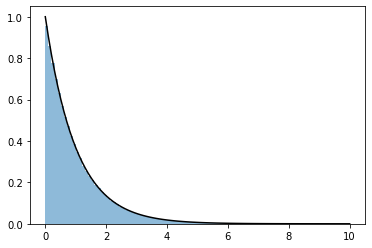

In [71]:
# Simulate arrivals and compare interval distribution to an exponential distribution

import scipy.stats as stats

N = 1000000
x = np.linspace(0, 10, 100)

diffs = np.diff(np.sort(N *np.random.rand(N)))
plt.hist(diffs, bins=x, density=True, alpha=0.5)
plt.plot(x, stats.expon.pdf(x, scale=1), '-k');
